In [77]:
import os
from typing import List, Tuple
import warnings
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


warnings.filterwarnings("ignore")

In [78]:
file_path = 'data/trainData.xlsx'
data = pd.read_excel(file_path)
data = data.set_index('datetime')
data['date'] = data.index.date
columns = ['date'] + [col for col in data.columns if col != 'date']
data = data[columns]
print(data.head())

                           date   open   high    low  close  volume
datetime                                                           
2017-07-03 08:45:00  2017-07-03  10260  10274  10243  10248   20893
2017-07-03 09:15:00  2017-07-03  10247  10289  10244  10283   22304
2017-07-03 09:45:00  2017-07-03  10283  10285  10255  10264   12600
2017-07-03 10:15:00  2017-07-03  10264  10270  10231  10244   16662
2017-07-03 10:45:00  2017-07-03  10244  10256  10236  10256    7213


In [79]:
initial_capital = 100000000
current_cumulative_return = 1
slippage = 0.001
l_stop_loss = 200
l_take_profit = 500
s_stop_loss = 100
s_take_profit = 250
commission = 50
tax_rate = 0.00002
unit_dollar = 200
short_window = 5
middle_window = 20
long_window = 60
window_size = 14
#Use short-term EMA, midterm EMA and long-term to capture the trend

In [80]:
data['short_ema'] = data['close'].ewm(span=short_window, adjust=False).mean()
data['middle_ema'] = data['close'].ewm(span=middle_window, adjust=False).mean()
data['long_ema'] = data['close'].ewm(span=long_window, adjust=False).mean()
data['typical price'] = (data['high'] + data['low'] + data['close']) / 3
data['money flow'] = data['typical price'] * data['volume']
data['positive cash flow'] = data['money flow'].where(data['typical price'] > data['typical price'].shift(1), 0).rolling(window=window_size).sum()
data['negative cash flow'] = data['money flow'].where(data['typical price'] < data['typical price'].shift(1), 0).rolling(window=window_size).sum()
data['money ratio'] = data['positive cash flow'] / data['negative cash flow']
data['mfi'] = 100 - (100 / (1 + data['money ratio']))

In [81]:

data['change'] = data['close'].diff()
data['up_wave'] = pd.NA
data['down_wave'] = pd.NA
data['max_up_wave'] = pd.NA
data['check'] = None
data['impulse'] = None
data.fillna(0, inplace=True)
for i in tqdm(range(1, len(data))):
    if data['change'].iloc[i] == 0:
        if data['up_wave'].iloc[i - 1] == 0:
            negative_change = data['change'].iloc[i]
            data['down_wave'].iloc[i] =  + data['down_wave'].iloc[i - 1] + negative_change
            data['up_wave'].iloc[i] = 0
            data['max_up_wave'].iloc[i] = data['max_up_wave'].iloc[i -1]
            if abs(data['down_wave'].iloc[i]) > data['max_up_wave'].iloc[i]:
                if data['check'].iloc[i - 1] == True:
                    data['impulse'].iloc[i] = True
                    data['check'] = None
                else:
                    data['check'].iloc[i] = True
            else:
                data['check'] = None
        elif data['down_wave'].iloc[i - 1] == 0:        
            positive_change = data['change'].iloc[i]
            data['up_wave'].iloc[i] =  + data['up_wave'].iloc[i - 1] + positive_change
            data['down_wave'].iloc[i] = 0
            data['max_up_wave'].iloc[i] = data['up_wave'].iloc[i]
            if data['check'].iloc[i - 1] == True:
                data['check'].iloc[i] = True
    elif data['change'].iloc[i] > 0:
        positive_change = data['change'].iloc[i]
        data['up_wave'].iloc[i] =  + data['up_wave'].iloc[i - 1] + positive_change
        data['down_wave'].iloc[i] = 0
        data['max_up_wave'].iloc[i] = data['up_wave'].iloc[i]
        if data['check'].iloc[i - 1] == True:
            data['check'].iloc[i] = True
    elif data['change'].iloc[i] < 0:
        negative_change = data['change'].iloc[i]
        data['down_wave'].iloc[i] =  + data['down_wave'].iloc[i - 1] + negative_change
        data['up_wave'].iloc[i] = 0
        data['max_up_wave'].iloc[i] = data['max_up_wave'].iloc[i -1]
        if abs(data['down_wave'].iloc[i]) > data['max_up_wave'].iloc[i]:
            if data['check'].iloc[i - 1] == True:
                data['impulse'].iloc[i] = True
                data['check'] = None
            else:
                data['check'].iloc[i] = True
        else:
            data['check'] = None

if "data/full_information.xlsx" not in os.listdir():
    data.to_excel("data/full_information.xlsx")
else:
    pass

100%|██████████| 46346/46346 [00:25<00:00, 1783.67it/s]


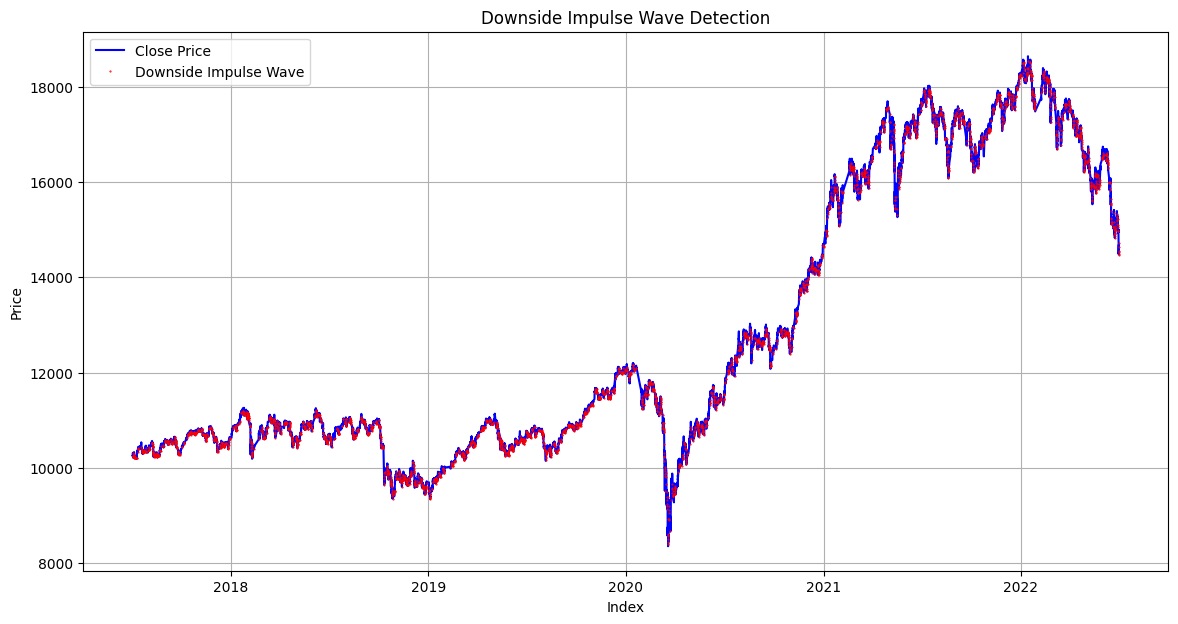

In [82]:
plt.figure(figsize=(14, 7))
plt.plot(data['close'], label='Close Price', color='blue')
plt.plot(
    data[data['impulse'] == True].index, 
    data['close'][data['impulse'] == True], 
    'ro',
    markersize=0.5,
    label='Downside Impulse Wave'
)
plt.title('Downside Impulse Wave Detection')
plt.xlabel('Index')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

In [83]:
trade_df = pd.DataFrame(columns=['Entry Datetime', 'Condition', 'Entry Price', 'Exit Datetime', 'Exit Price', 'Trade Profit', 'Net Profit', 'Trade Return'])
cumulative_return_tracking = pd.DataFrame(index=data.index,columns = ['Cumulative Return'])
cumulative_return_tracking['Cumulative Return'].iloc[0] = current_cumulative_return

In [84]:
file_path ='data/settlementDate.xlsx'
sd = pd.read_excel(file_path)
sd.columns = ['No.', 'settlementDate', 'futures', 'settlementPrice']
sd = sd.drop('No.', axis=1)
print(sd.head())

  settlementDate   futures  settlementPrice
0     2024-07-26  202407W4            22069
1     2024-07-17    202407            23680
2     2024-07-10  202407W2            23996
3     2024-07-03  202407W1            23138
4     2024-06-26  202406W4            22965


In [85]:
bool_ = [False if 'W' in str(i) else True for i in sd['futures']]
settlementDate = [str(i).replace('/','-') for i in list(sd[bool_]['settlementDate'])]
settlementDate = [pd.to_datetime(i).date() for i in settlementDate]
print(settlementDate[-5:])

[datetime.date(1999, 1, 21), datetime.date(1998, 12, 17), datetime.date(1998, 11, 19), datetime.date(1998, 10, 22), datetime.date(1998, 9, 17)]


In [86]:
time_arr = np.array(data.index)
date_arr = [pd.to_datetime(i).date() for i in time_arr]
print(date_arr[:5])

[datetime.date(2017, 7, 3), datetime.date(2017, 7, 3), datetime.date(2017, 7, 3), datetime.date(2017, 7, 3), datetime.date(2017, 7, 3)]


In [87]:
import datetime


def condition(
    data: pd.DataFrame,
    settlementDate: List[int],
    daily_trade: bool,
    date_arr: List[datetime.date],
    k: int,
    scenario: str
) -> Tuple[bool]:
    """
    Entry condition for the trading strategy.
    """
    if scenario == "entry":
        long = (
            data['short_ema'].iloc[k] > data['middle_ema'].iloc[k] > data['long_ema'].iloc[k]
        ) and (
            data['high'].iloc[k] > data['high'].iloc[k - 1]
        ) and (
            data['low'].iloc[k] > data['low'].iloc[k - 1]
        )
        short = (
            data['long_ema'].iloc[k] > data['middle_ema'].iloc[k] > data['short_ema'].iloc[k]
        ) and (
            data['impulse'].iloc[k] == True
        )
        cond = (date_arr[k] not in settlementDate) and (daily_trade is None)

    elif scenario == "exit":
        long = (
            data['short_ema'].iloc[j] < data['middle_ema'].iloc[j] < data['long_ema'].iloc[j]
        ) or (
            data['mfi'].iloc[j] > 80
        )
        short = (
            data['long_ema'].iloc[j] < data['middle_ema'].iloc[j] < data['short_ema'].iloc[j]
        ) or (
            data['mfi'].iloc[j] < 20
        )
        cond = date_arr[j] in settlementDate

    else:
        raise ValueError("Invalid scenario.")

    return long, short, cond


Condition = None
daily_trade = None
buy = []
sell = []
sellshort = []
buytocover = []
returns = []

for i in tqdm(range(1, len(data))):

    if i == len(data)-1:
        break
    
    if data['date'].iloc[i] != data['date'].iloc[i - 1]:
        daily_trade = None

    # entry condition
    entry_long, entry_short, entry_condition = condition(data, settlementDate, daily_trade, date_arr, i, "entry")

    if Condition == None:

        if entry_long and entry_condition:
            Condition = 'B'
            t = i + 1
            entry_price = data['open'].iloc[t] * (1 + slippage)
            new_row = {'Entry Datetime' : data.index[t], 'Original Price' : data['open'].iloc[t], 'Condition' : 'B', 'Entry Price' : entry_price}
            buy.append(t)
            daily_trade = True 
        
            for j in range(t + 1, len(data)):
                exit_long, exit_short, exit_condition = condition(
                    data, settlementDate, daily_trade, date_arr, j, "exit"
                )

                if exit_long or exit_condition or (data['close'].iloc[j] <=  entry_price - l_stop_loss) or (data['close'].iloc[j] >=  entry_price + l_take_profit):
                    exit_price = min(max(data['close'].iloc[j] * (1 - slippage), data['open'].iloc[t] - l_stop_loss), data['open'].iloc[t] + l_take_profit)
                    new_row['Exit Datetime'] = data.index[j]
                    new_row['Exit Price'] = exit_price
                    trade_profit = (exit_price - entry_price) * unit_dollar
                    net_profit = (exit_price - entry_price) * unit_dollar - commission - exit_price * unit_dollar * tax_rate - entry_price * unit_dollar * tax_rate
                    trade_return = (net_profit / (entry_price * unit_dollar))
                    current_cumulative_return += trade_return
                    cumulative_return_tracking['Cumulative Return'].iloc[j] = current_cumulative_return
                    new_row['Trade Profit'] = trade_profit
                    new_row['Net Profit'] = net_profit
                    new_row['Trade Return'] = trade_return
                    new_row_df = pd.DataFrame([new_row])
                    trade_df = pd.concat([trade_df, new_row_df], ignore_index=True)
                    Condition = None
                    break

        elif entry_short and entry_condition:
            Condition = 'S'
            t = i + 1
            entry_price = data['open'].iloc[t] * (1 - slippage)
            new_row = {'Entry Datetime' : data.index[t], 'Original Price' : data['open'].iloc[t], 'Condition' : 'S', 'Entry Price' : entry_price}
            sellshort.append(t)
            daily_trade = True 

            for j in range(t + 1, len(data)):
                exit_long, exit_short, exit_condition = condition(
                    data, settlementDate, daily_trade, date_arr, j, "exit"
                )

                if exit_short or exit_condition or (data['close'].iloc[j] >=  entry_price + s_stop_loss) or (data['close'].iloc[j] <=  entry_price - s_take_profit):
                    exit_price = max(min(data['close'].iloc[j] * (1 + slippage), data['open'].iloc[t] + s_stop_loss), data['open'].iloc[t] - s_take_profit)
                    new_row['Exit Datetime'] = data.index[j]
                    new_row['Exit Price'] = exit_price
                    trade_profit = -(exit_price - entry_price) * unit_dollar
                    net_profit = -(exit_price - entry_price) * unit_dollar - commission - exit_price * unit_dollar * tax_rate - entry_price * unit_dollar * tax_rate
                    trade_return = (net_profit / (entry_price * unit_dollar))
                    current_cumulative_return += trade_return
                    cumulative_return_tracking['Cumulative Return'].iloc[j] = current_cumulative_return
                    new_row['Trade Profit'] = trade_profit
                    new_row['Net Profit'] = net_profit
                    new_row['Trade Return'] = trade_return
                    new_row_df = pd.DataFrame([new_row])
                    trade_df = pd.concat([trade_df, new_row_df], ignore_index=True)
                    Condition = None
                    break

trade_df.to_excel("data/trade_record.xlsx")

100%|█████████▉| 46345/46346 [00:03<00:00, 12689.06it/s]


(array([ 1.,  0.,  0.,  0.,  1.,  2.,  0.,  2.,  0.,  0.,  1.,  0.,  0.,
         3.,  1.,  2.,  5.,  7.,  7.,  6.,  7., 12., 10., 18., 23., 19.,
        21., 16., 16., 32., 47., 31., 19., 19., 18., 10., 17., 13., 31.,
        52., 78., 89., 79., 68., 60., 57., 39., 56., 39., 27., 30., 33.,
        19., 13., 16., 23., 12.,  9., 11.,  5.,  6., 14., 10., 10.,  2.,
         2.,  3.,  1.,  4.,  5.,  1.,  2.,  5.,  0.,  1.,  3.,  1.,  1.,
         1.,  1.,  0.,  0.,  0.,  1.,  2.,  0.,  0.,  0.,  1.,  1.,  0.,
         1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  1.]),
 array([-0.02174982, -0.0212635 , -0.02077719, -0.02029088, -0.01980456,
        -0.01931825, -0.01883194, -0.01834563, -0.01785931, -0.017373  ,
        -0.01688669, -0.01640037, -0.01591406, -0.01542775, -0.01494144,
        -0.01445512, -0.01396881, -0.0134825 , -0.01299618, -0.01250987,
        -0.01202356, -0.01153725, -0.01105093, -0.01056462, -0.01007831,
        -0.009592  , -0.00910568, -0.00861937, -0.00813306, -0.007646

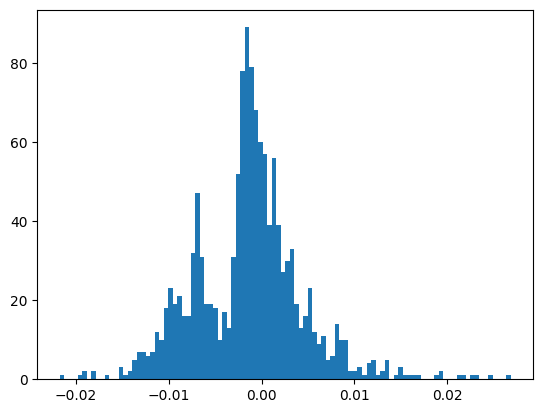

In [90]:
plt.hist(trade_df['Trade Return'], bins=100)